<h3>PHY 240 - Spring 2016</h3>
Team: Katherine Hendrick, Jessamine Huang, and Samuel Barton
<hr size=10pt>
<i>Data Analysis - Written by Samuel Barton</i>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline
from matplotlib import rc
from pylab import rcParams
import statsmodels.api as sm
import uncertainties as un
from uncertainties import ufloat

# Constants

#Permiability of free space
mu_0 = 4*np.pi*10**(-7)
# number of turns in each Helmholtz coil
N = ufloat(72, 1)
# the mean radius of the Helmholtz coils (in m)
a = ufloat(0.33, 0.005)

This is how you customize the global look and feel settings for matplotlib. See http://matplotlib.org/users/customizing.html for more details. 

In [120]:
rc('text', usetex=True)

params = {
    'font.family': 'serif',
    'font.size': 16,
    'font.serif': ['Computer Modern'],
    'figure.figsize': (10,8),
    'legend.numpoints': 1,
    'legend.fontsize': 16,
    'legend.fancybox': True,
}

plt.rcParams.update(params)

In [4]:
def linearFit(t, m, b): 
    return m*t + b

Variables with uncertainty:
 - V $\pm$ 2 volts
 - N $\pm$ 1 turn
 - R $\pm$ 1 millimerter
 - I $\pm$ 0.2 amps
 - a $\pm$ 0.5 centimeters
 

<h3>Reading in our data</h3>

<p>Below we read in our data from a collection of data files in another directory. The arrays generated by reading in these files are appended to our dataset array, such that we have our entire dataset in a single object.</p>

In [5]:
dataset = []
diameter_values = [0.115, 0.103, 0.090, 0.078, 0.065]
radii = [x/2 for x in diameter_values]

# Range is inclusive, thus even though the filenames run from v1r1 through v7r5, we need upper limits of 8 and 6.
for run_num in range(1,8):
    for R_num in range(1,6):
        dataset.append(np.genfromtxt("../data/v{0}r{1}.txt".format(run_num, R_num), skip_header=True))

Now that we have our data, we need to calculate the column averages for each run.

In [6]:
averages = [run.mean(axis=0) for run in dataset]

Now that we have calculated the averages, we are going to replace the 0th field of each row, currently holding the time, with the radius for that run.

In [7]:
rad_index = 0
for run in averages:
    run[0] = radii[rad_index]
    rad_index += 1
    if (rad_index == 5):
        rad_index = 0

In [8]:
# These labels are for the values in averages
labels = ["R (m)", "B (mT)", "I (A)", "V (V)"]

print(labels)
averages

['R (m)', 'B (mT)', 'I (A)', 'V (V)']


[array([  0.0575    ,   0.35527826,   2.06854256,  29.85735903]),
 array([  0.0515    ,   0.3805583 ,   2.28701536,  29.85460338]),
 array([  0.045     ,   0.38050802,   2.58383689,  29.85532855]),
 array([  0.039     ,   0.38043454,   2.97924697,  29.8525729 ]),
 array([  0.0325    ,   0.38034365,   3.41911728,  29.85474841]),
 array([  0.0575    ,   0.34216211,   2.00572106,  27.7437871 ]),
 array([  0.0515    ,   0.38059287,   2.22484164,  27.74465731]),
 array([  0.045     ,   0.38056205,   2.51140561,  27.74393214]),
 array([  0.039     ,   0.38049062,   2.88510865,  27.74523744]),
 array([  0.0325    ,   0.38039973,   3.40176008,  27.743352  ]),
 array([  0.0575    ,   0.33549671,   1.97672976,  26.01412934]),
 array([  0.0515    ,   0.37712184,   2.18666485,  26.01470947]),
 array([  0.045     ,   0.38056217,   2.4384561 ,  26.0139843 ]),
 array([  0.039     ,   0.38049062,   2.80882633,  26.01427437]),
 array([  0.0325    ,   0.38049062,   2.80882633,  26.01427437]),
 array([  

Calculate the value for $B$ (in T) so that we can compare it to our measured value for $B$. also, put the uncertainties into $I$, $V$, and $R$, and put the resulting ufloat values into a new array.

In [9]:
I_ex_with_uncert = []
b_calc_with_uncert = []
b_experimental = []
I_experimental = []
V_experimental = []
V_ex_with_uncert = []
r_val_with_uncert = []
for run in averages:
    b_experimental.append(run[1])
    I_experimental.append(run[2])
    V_experimental.append(run[3])
    V_ex_with_uncert.append(ufloat(run[3], 2))
    r_val_with_uncert.append(ufloat(run[0], 0.001))
    I = ufloat(run[2], 0.2)
    I_ex_with_uncert.append(I)
    b_calc_with_uncert.append(((8*mu_0*N*I)/(a*np.sqrt(125))))

Now that we have calculated each value for B, we can compare it to our experimental values.

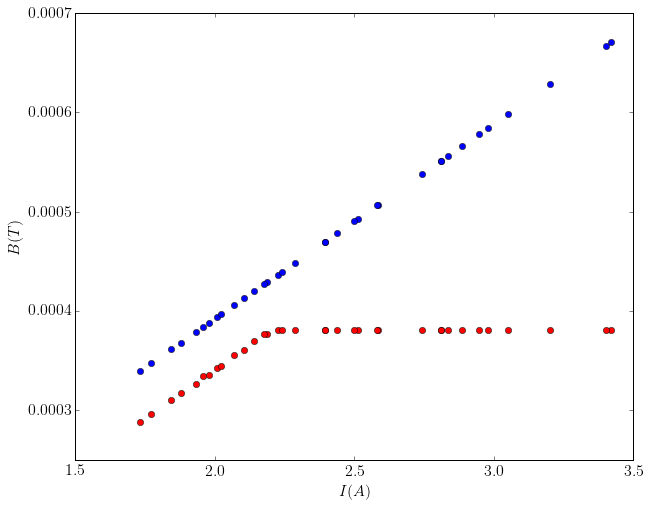

In [10]:
# make a list with b in units of Tesla
be_in_T = [b/1000 for b in b_experimental]

# Pull out the "nominal value" (the actual number instead of the uncertainty) from the calculated b.
b_calculated = [val.n for val in b_calc_with_uncert]

plt.plot(I_experimental, b_calculated,"bo")
plt.plot(I_experimental, be_in_T,"ro")
plt.xlabel(r'$I (A)$')
plt.ylabel(r'$B (T)$')
plt.show()
#for (index = 0; index < len(b_calculated); index++):
#    print("Calculated {0} mT\tExperimental {1} mT".format(b_calculated[index], averages[index][2]))

We see from this plot that our measuring device for B became saturated at about 2.2A, thus the straight line we see. So, we are going to calculate the average difference between our calculated and experimental values for B before our experimental value diverges, and then apply the offset generated by that average on the calculated B to get an estimate of B for a given current. 

In [11]:
avg = 0
be_s = np.sort(be_in_T)
bc_s = np.sort(b_calculated)
for i in range(0,13):
    avg += be_s[i]-bc_s[i]
    
avg = avg/12

print ("Average difference between calculated B and experimental B: "+str(np.round(avg, decimals=10)) + " T")

Average difference between calculated B and experimental B: -5.54667e-05 T


We will use the averages calculated above to generate a new list of $B$ values which we will use for B going forward.

We will do this by subtracting the average difference between our experimental and calculated $B$ values from the calculated $B$ value and puting the result (with the uncertainties from the calculated $B$) into a new list.

In [12]:
b_est_with_uncert = [ufloat(val.n + avg, val.s) for val in b_calc_with_uncert]

# This list is here so we can graph our estimate for b.
b_estimate = [b.n for b in b_est_with_uncert]

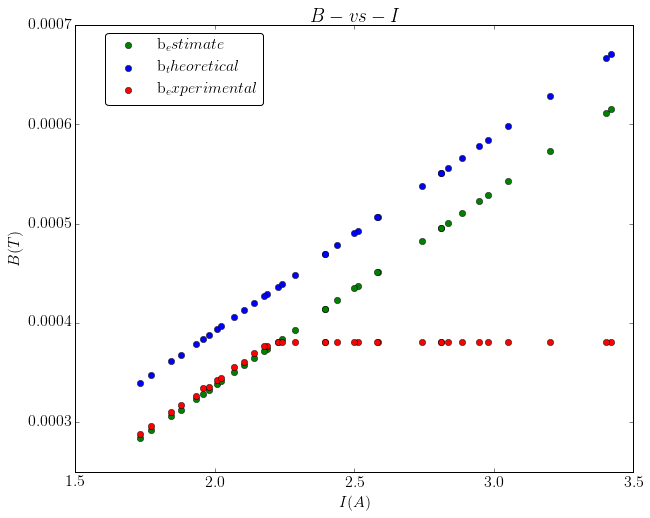

In [13]:
plt.plot(I_experimental, b_estimate, 'go', label="b_estimate")
plt.plot(I_experimental, b_calculated,"bo", label="b_theoretical")
plt.plot(I_experimental, be_in_T,"ro", label="b_experimental")
plt.xlabel(r'$I (A)$')
plt.ylabel(r'$B (T)$')
plt.legend(bbox_to_anchor=(0.35,1))
plt.title(r'$B - vs - I$')
plt.savefig('../images/comparing_b.png', bbox_inches=0, dpi=600)
plt.show()

This graph shows the calculateed value for B, the experimental value for B, and the estimated value for B, all versus the experimental value for I.

In [14]:
x_axis_with_uncert = []
i = 0
while (i < len(b_est_with_uncert)):
    x_axis_with_uncert.append(1/2*(b_est_with_uncert[i]**2)*(r_val_with_uncert[i]**2))
    i += 1    

# Used for plotting
x_axis = [val.n for val in x_axis_with_uncert]

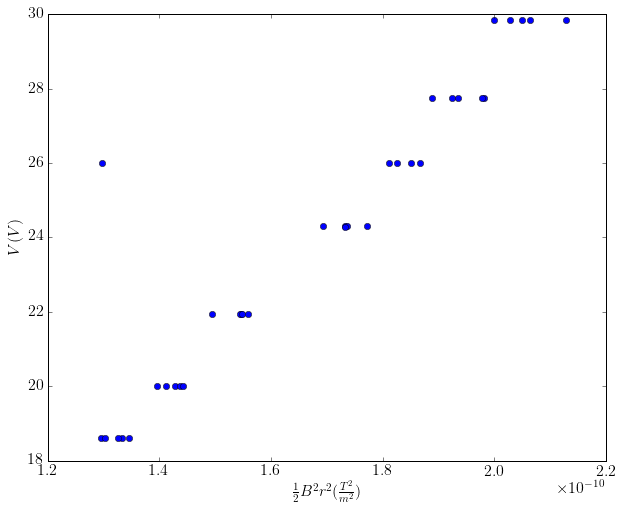

In [15]:
plt.plot(x_axis, V_experimental, 'o')
plt.xlabel(r'$\frac{1}{2} B^2 r^2 (\frac{T^2}{m^2})$')
plt.ylabel(r'$V (V)$')
plt.show()

Above is a plain plot of our data. We know that the value of $\frac{e}{m}$, from <a href=https://en.wikipedia.org/wiki/Mass-to-charge_ratio>Wikipedia</a>, is given at $1.758820024×10^{11} C/kg$.

Before getting the best fit line, we are going to get rid of the outlier we see at point (1.2xxx$e^-10$, 26.xx). To do this we'll first find the problem cell by printing out both axes and using visual inspection to find a point with y $\approx$ 26 and x $\approx$ $1.2\times 10^{-10}$.

In [16]:
print("Index\tV_experimental\tx_axis")
for i in range(0, len(V_experimental)):
    print("{}\t{:.3f}\t{:.3e}".format(i, V_experimental[i], x_axis[i]))

Index	V_experimental	x_axis
0	29.857	2.029e-10
1	29.855	2.050e-10
2	29.855	2.063e-10
3	29.853	2.128e-10
4	29.855	2.000e-10
5	27.744	1.889e-10
6	27.745	1.925e-10
7	27.744	1.936e-10
8	27.745	1.982e-10
9	27.743	1.977e-10
10	26.014	1.826e-10
11	26.015	1.850e-10
12	26.014	1.811e-10
13	26.014	1.868e-10
14	26.014	1.297e-10
15	24.295	1.732e-10
16	24.296	1.693e-10
17	24.296	1.737e-10
18	24.296	1.773e-10
19	24.294	1.733e-10
20	21.948	1.546e-10
21	21.947	1.544e-10
22	21.949	1.495e-10
23	21.946	1.547e-10
24	21.945	1.558e-10
25	20.002	1.412e-10
26	20.003	1.428e-10
27	20.001	1.397e-10
28	20.002	1.438e-10
29	20.002	1.443e-10
30	18.607	1.334e-10
31	18.606	1.296e-10
32	18.608	1.345e-10
33	18.608	1.303e-10
34	18.608	1.325e-10


The index we are looking for is 14. So now we'll remove that index from all four arrays.

In [17]:
V_experimental[14] = 0
V_ex_with_uncert[14] = ufloat(0,0)
x_axis[14] = 0
x_axis_with_uncert[14] = ufloat(0,0)

x_axis = [x for x in x_axis if x != 0]
x_axis_with_uncert = [x for x in x_axis_with_uncert if x.n != 0]
V_experimental = [V for V in V_experimental if V != 0]
V_ex_with_uncert = [V for V in V_ex_with_uncert if V.n != 0]
print("Index\tV_experimental\tx_axis")
for i in range(0, len(V_experimental)):
    print("{}\t{:.3f}\t{:.3e}".format(i, V_experimental[i], x_axis[i]))
    
x_axis_error = [x.s for x in x_axis_with_uncert]
y_axis_error = [y.s for y in V_ex_with_uncert]

Index	V_experimental	x_axis
0	29.857	2.029e-10
1	29.855	2.050e-10
2	29.855	2.063e-10
3	29.853	2.128e-10
4	29.855	2.000e-10
5	27.744	1.889e-10
6	27.745	1.925e-10
7	27.744	1.936e-10
8	27.745	1.982e-10
9	27.743	1.977e-10
10	26.014	1.826e-10
11	26.015	1.850e-10
12	26.014	1.811e-10
13	26.014	1.868e-10
14	24.295	1.732e-10
15	24.296	1.693e-10
16	24.296	1.737e-10
17	24.296	1.773e-10
18	24.294	1.733e-10
19	21.948	1.546e-10
20	21.947	1.544e-10
21	21.949	1.495e-10
22	21.946	1.547e-10
23	21.945	1.558e-10
24	20.002	1.412e-10
25	20.003	1.428e-10
26	20.001	1.397e-10
27	20.002	1.438e-10
28	20.002	1.443e-10
29	18.607	1.334e-10
30	18.606	1.296e-10
31	18.608	1.345e-10
32	18.608	1.303e-10
33	18.608	1.325e-10


We will now use the statsmodel OLS function to get the best fit line for our data, with the line being constrained to go through the origin. 

In [18]:
est = sm.OLS(V_experimental, x_axis)
est = est.fit()

x_prime = np.linspace(np.amin(x_axis), np.amax(x_axis), 100)
#x_prime = np.linspace(0, np.amax(X), 1000)
#x_prime = sm.add_constant(x_prime)
y_predicted = est.predict(x_prime)

est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 7.734e+04
Date:                Sun, 21 Feb 2016   Prob (F-statistic):           3.41e-57
Time:                        17:05:10   Log-Likelihood:                -24.824
No. Observations:                  34   AIC:                             51.65
Df Residuals:                      33   BIC:                             53.17
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1          1.423e+11   5.12e+08    278.109      0.000      1.41e+11  1.43e+11
==============================================================================
Omnibus:                        5.922   Durbin-Watson:                   1.283
Prob(Omnibus):                  0.052   Jarque-Bera (JB):                4.615
Skew:                           0.875   Prob(JB):                       0.0995
Kurtosis:                       3.440   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 9.92e-19. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [80]:
print("Uncertainties package slope calculation:")

e_over_m = []

for i in range(0, len(V_ex_with_uncert)):
    e_over_m.append(V_ex_with_uncert[i]/x_axis_with_uncert[i])

e_over_m_uncert = [val.s for val in e_over_m]
mean_e_over_m_uncert = np.mean(e_over_m_uncert)
print("Slope: {:.3e} +/- {:.3e}".format(est.params[0], mean_e_over_m_uncert))

x_vals = [np.amin(x_axis), np.amax(x_axis)]

const = 5.5
min_slope = est.params[0] - mean_e_over_m_uncert
y_min_vals = [linearFit(x_vals[0], min_slope, const), 
          linearFit(x_vals[1], min_slope, const)] 

max_slope = est.params[0] + mean_e_over_m_uncert
y_max_vals = [linearFit(x_vals[0], max_slope, -const), 
          linearFit(x_vals[1], max_slope, -const)] 

Uncertainties package slope calculation:
Slope: 1.423e+11 +/- 3.196e+10


/Users/samuelbphotos/anaconda/envs/py34/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


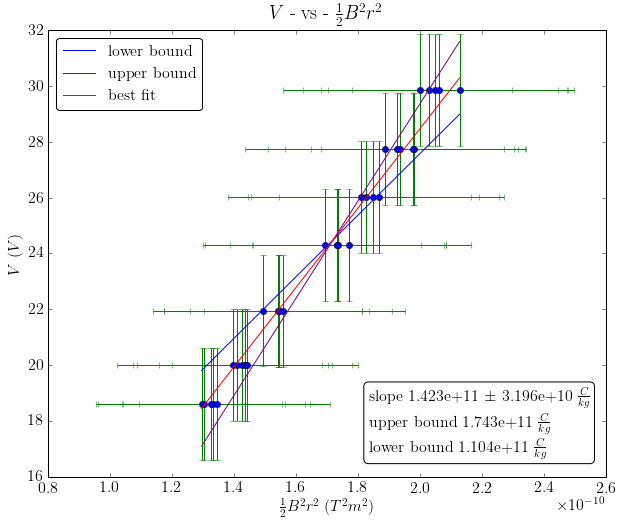

In [125]:
plt.errorbar(x_axis, V_experimental, xerr=x_axis_error, yerr=y_axis_error, linestyle='none', fmt='g')
plt.plot(x_axis, V_experimental, 'bo')
plt.plot(x_vals, y_min_vals, 'b', label='lower bound')
plt.plot(x_vals, y_max_vals, 'purple', label='upper bound')
plt.plot(x_prime, y_predicted, 'r', label='best fit')  # Add the regression line, colored in red
plt.xlabel(r'$\frac{1}{2} B^2 r^2$  $(T^2 m^2)$', fontsize=16)
plt.ylabel(r'$V$  $(V)$', fontsize=16)
plt.title(r'$V$ - vs - $\frac{1}{2}B^2r^2$')
plt.legend(bbox_to_anchor=(0.29,1))
props = dict(boxstyle='round', facecolor='white')
plt.text(1.835e-10, 16.75, 
         "slope {:.3e} $\pm$ {:.3e}  ".format(est.params[0], mean_e_over_m_uncert)+
         r'$\frac{C}{kg}$'+"\n"+
         "upper bound {:.3e}  ".format(max_slope)+r'$\frac{C}{kg}$'+"\n"
         "lower bound {:.3e}  ".format(min_slope)+r'$\frac{C}{kg}$',bbox=props)
#plt.savefig('../images/e_over_m.png', bbox_inches=0, dpi=600)
plt.show()

The slope of the best fit line is $\frac{e}{m}$. Below we calculate the uncertainty in our slope.

For the final step we calculate the range of slopes we can cover within our uncertainty. And if the accepted value for $\frac{e}{m}$ is within that range, then we have succeeded in calculating it. This uncertainty is simply based on the difference of the data we measured, and is thus more restrictive than the uncertainties calculated by the uncertainties package. Those are listed below.

In [33]:
print("Range: {:.3e} –– {:.3e}".format((est.params[0] - mean_e_over_m_uncert),(est.params[0] + mean_e_over_m_uncert)))

Range: 1.104e+11 –– 1.743e+11


Within this range lies our target value of $1.758820024×10^{11} C/kg$. 

In [31]:
print("x-axis uncertainty: +/- {:.3e}".format(np.mean(x_axis_error)))
print("y-axis uncertainty: +/- {}".format(np.mean(y_axis_error)))

x-axis uncertainty: +/- 3.466e-11
y-axis uncertainty: +/- 2.0
